这里 我们使用普通RNN和SegRNN架构对比patch的作用

为什么要进行Patch？

我们希望收集一个长序列的信息

我们可以将RNN类的模型理解为一个顺序的信息收集器，这个收集器可以从前向后逐步遍历所有的时间步，

在每个时间步上，得到的信息储存是之前的历史信息+本次收集的信息，在最后用收集的信息进行输出

因为提升预测的需要，我们必须扩展序列长度，来获取更全面的信息；

但是如果总的距离过长，就必须压缩历史信息的占比，导致远距离信息微弱甚至丢失

而如果不压缩历史信息，会导致梯度爆炸。

因此我们可以参考CNN的思路，采用1维卷积的方式尝试解决这个问题：

首先，我们将原始序列分为长度为某个值子序列，然后每若干步采样一次。

在每个子序列内，可以使用Linear或RNN，尝试在序列中识别出小段的上涨趋势、下跌趋势和平盘之类的信息，并抽象为信息向量；

由于每个子序列内长度有限，RNN可以充分吸取信息而不必担心长序列信息丢失的问题。

如果此时的序列仍然过长，我们可以再加入一层，将上一层得到的子序列再分组为新的子序列，同样用Linear或RNN收集子序列信息。

在这一层我们可以识别出更复杂的形态组合，例如连续多端上涨之后的下跌，抑或是平盘之后的变盘形态等等。

直到整个序列的长度已经很小了，此时我们再使用RNN进行最后一次收集，并将的得到的信息向量传入输出层输出出我们需要的任务。

这样一来，每层的RNN都面对一个相对较小的子序列，不至于出现长距离信息丢失的问题

而不同层的RNN处理的问题是不一样的，其参数和方式也有所不同

In [58]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

import optuna
from utils import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [59]:
from modules.patch import SimplePatch
from modules.truncate import SequenceTruncate

class Patch_LSTM(nn.Module):
    """循环神经网络模型"""
    def __init__(self, input_size, patch_size, in_patch_hidden_size, in_patch_num_layers, hidden_size, num_layers, drop_1, drop_2, drop_3, drop_4, drop_5):
        super().__init__()
        self.device = 'cuda:0'
        self.input_size = input_size
        self.patch_size = patch_size
        self.in_patch_hidden_size = in_patch_hidden_size
        self.hidden_size = hidden_size

        self.sequence_truncate = SequenceTruncate(drop_1)

        self.simple_patch = SimplePatch(patch_size)

        self.inpatch_process = nn.LSTM(
            input_size = input_size,
            hidden_size = in_patch_hidden_size,
            num_layers = in_patch_num_layers,
            dropout = drop_2,
            batch_first = True,
            # nonlinearity='relu',
        )
        self.dropout = nn.Dropout(drop_3)

        self.process = nn.LSTM(
            input_size = in_patch_hidden_size, #第一层LSTM的隐藏层作为第二层的输入，因此第二层的input size = in_patch_hidden_size
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = drop_4,
            batch_first = True,
            # nonlinearity='relu',
        )
        
        self.output = nn.Sequential(
            nn.Dropout(drop_5),
            HybridDecoder(dim_state = hidden_size, init_prob = [0.0,0.5,0.0])
        )
        

    def forward(self, x):

        x_truncated = self.sequence_truncate(x)
        x_patched = self.simple_patch(x_truncated)
        num_patch = x_patched.shape[-3]
        front_size = tuple(x_patched.shape[:-2])
        x_rebatched = x_patched.reshape(-1, self.patch_size, self.input_size)
        x_processed_1 = self.inpatch_process(x_rebatched)[0][:,-1,:]
        x_recover = x_processed_1.reshape(*front_size, -1)
        front_size_2 = tuple(x_recover.shape[:-2])
        x_rebatched_2 = x_recover.reshape(-1, num_patch,  self.in_patch_hidden_size)
        x_rebatched_2 = self.dropout(x_rebatched_2)
        x_processed_2 = self.process(x_rebatched_2)[0][:,-1,:]
        x_recover_2 = x_processed_2.reshape(*front_size_2, self.hidden_size)
        
        return self.output(x_recover_2)


最佳试验的编号:  83
最佳准确率:  1.5396911809958544
最佳超参数:  {'batch_size': 512, 'seq_len': 120, 'hidden_size': 15, 'patch_size': 20, 'in_patch_hidden_size': 15, 'drop_1': 0.2738123113465603, 'drop_2': 0.045764890992659346, 'drop_3': 0.34029596057871897, 'drop_4': 0.24400026928034624, 'drop_5': 0.45016697728695354}

最佳准确率:  1.5986929069299993
最佳超参数:  {'batch_size': 512, 'seq_len': 120, 'patch_size': 20, 'in_patch_hidden_size': 15, 'in_patch_num_layers': 1, 'hidden_size': 15, 'num_layers': 1, 'drop_2': 0.13471707877611394, 'drop_3': 0.3806117238543563}

最佳准确率:  2.1445717383196663
最佳超参数:  {'batch_size': 512, 'seq_len': 120, 'patch_size': 20, 'in_patch_hidden_size': 15, 'in_patch_num_layers': 1, 'hidden_size': 15, 'num_layers': 1, 'drop_2': 0.10879170358100562, 'drop_3': 0.32737123192315337}

最佳准确率:  2.7420650622479976
最佳超参数:  {'batch_size': 512, 'patch_size': 20, 'in_patch_hidden_size': 15, 'in_patch_num_layers': 1, 'seq_len': 120, 'hidden_size': 10, 'num_layers': 1, 'drop_1': 0.30882919041585727, 'drop_4': 0.15790008475668355, 'drop_5': 0.5949612766008797}

In [60]:
def objective(trial):

    # 模型训练超参数
    batch_size = trial.suggest_categorical("batch_size", [512])
    
    learning_rate = 0.00414204048742639
    # learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True) # 对数均匀分布
    
    weight_decay = 1.5049917025821792e-05
    # weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    
    alpha = 0.06775404079302666
    # alpha = trial.suggest_float('alpha', 1e-2, 1e-1)


    # 细粒度超参数
    patch_size = trial.suggest_categorical('patch_size', [20])
    in_patch_hidden_size = trial.suggest_categorical('in_patch_hidden_size', [15])
    in_patch_num_layers = trial.suggest_categorical('in_patch_num_layers', [1])
    # drop_2 = trial.suggest_float("drop_2", 0.0, 0.2)
    drop_2 = 0.10879170358100562
    # drop_3 = trial.suggest_float("drop_3", 0.2, 0.4)
    drop_3 = 0.32737123192315337

    # 粗粒度超参数
    seq_len = trial.suggest_categorical("seq_len", [120])
    hidden_size = trial.suggest_categorical('hidden_size', [10])
    num_layers = trial.suggest_categorical('num_layers', [1])

    drop_1 = 0.30882919041585727
    # drop_1 = trial.suggest_float("drop_1", 0.1, 0.4)

    drop_4 = 0.15790008475668355
    # drop_4 = trial.suggest_float("drop_4", 0.1, 0.4)

    drop_5 = 0.5949612766008797
    # drop_5 = trial.suggest_float("drop_5", 0.4, 0.6)
    
    

    # 提取数据
    feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
    label_columns = ['label_return','down_prob','middle_prob','up_prob']
    assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
    assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]
    feature = []
    label = []

    for asset_code in assets_list:
        data = pd.read_csv(f'data/{asset_code}.csv')
        feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
        label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

    # 加载数据
    feature = torch.stack(feature, dim = 1)
    label = torch.stack(label, dim = 1)
    print(feature.shape, label.shape)

    # 折叠时间步
    feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
    label = label[seq_len-1:]
    print(feature.shape, label.shape)

    data = RandomLoader(feature, label)
    recorder = PredictionRecorder()
    animator = TrainMonitor(figsize=(12,6))

    result = np.zeros(shape = (10, len(assets_list), 4))
    precision_list = []

    result = []
    for i in range(10):
        j = 0
        train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.6, 0.1], balance=[True, False])

        for x ,y in train_loader:
            print(x.shape)
            break
        
        animator.reset()
        loss_fn = HybridLoss(alpha = alpha, delta = 1.35, show_loss = False) #控制损失在1：3左右
        model = Patch_LSTM(input_size = 10,
                           patch_size = patch_size,
                           in_patch_hidden_size = in_patch_hidden_size,
                           in_patch_num_layers = in_patch_num_layers,
                           hidden_size = hidden_size,
                           num_layers = num_layers,
                           drop_1 = drop_1,
                           drop_2 = drop_2,
                           drop_3 = drop_3,
                           drop_4 = drop_4,
                           drop_5 = drop_5,
                           ).to('cuda:0')
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        train = ModelTrain(model = model,
                    train_loader = train_loader,
                    test_loader = test_loader,
                    loss_fn = loss_fn,
                    optimizer = optimizer,
                    scheduler = scheduler,
                    recorder = recorder,
                    graph = animator,
                    )
        prediction, precision = train.epoch_train(epochs = 10, early_stop = 100)

        precision_list.append(precision)


    return np.mean(precision_list)/np.std(precision_list)

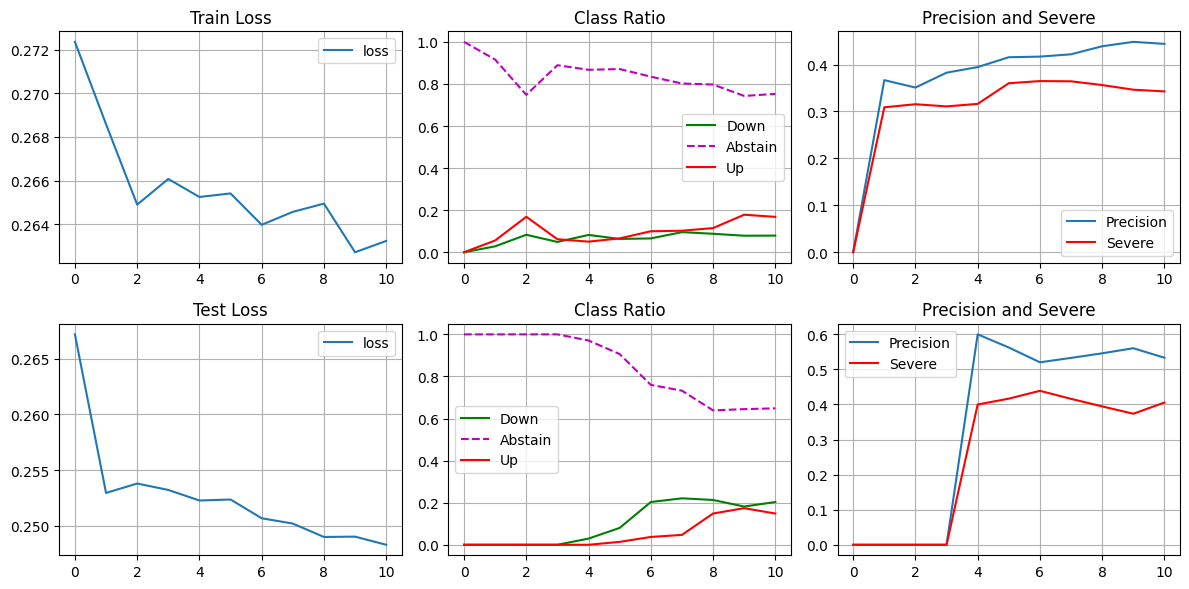

100%|██████████| 1/1 [00:00<00:00, 138.43it/s]
[I 2025-10-04 19:48:10,677] Trial 0 finished with value: 1.9802244549675343 and parameters: {'batch_size': 512, 'patch_size': 20, 'in_patch_hidden_size': 15, 'in_patch_num_layers': 1, 'seq_len': 120, 'hidden_size': 10, 'num_layers': 1}. Best is trial 0 with value: 1.9802244549675343.


最佳准确率:  1.9802244549675343
最佳超参数:  {'batch_size': 512, 'patch_size': 20, 'in_patch_hidden_size': 15, 'in_patch_num_layers': 1, 'seq_len': 120, 'hidden_size': 10, 'num_layers': 1}


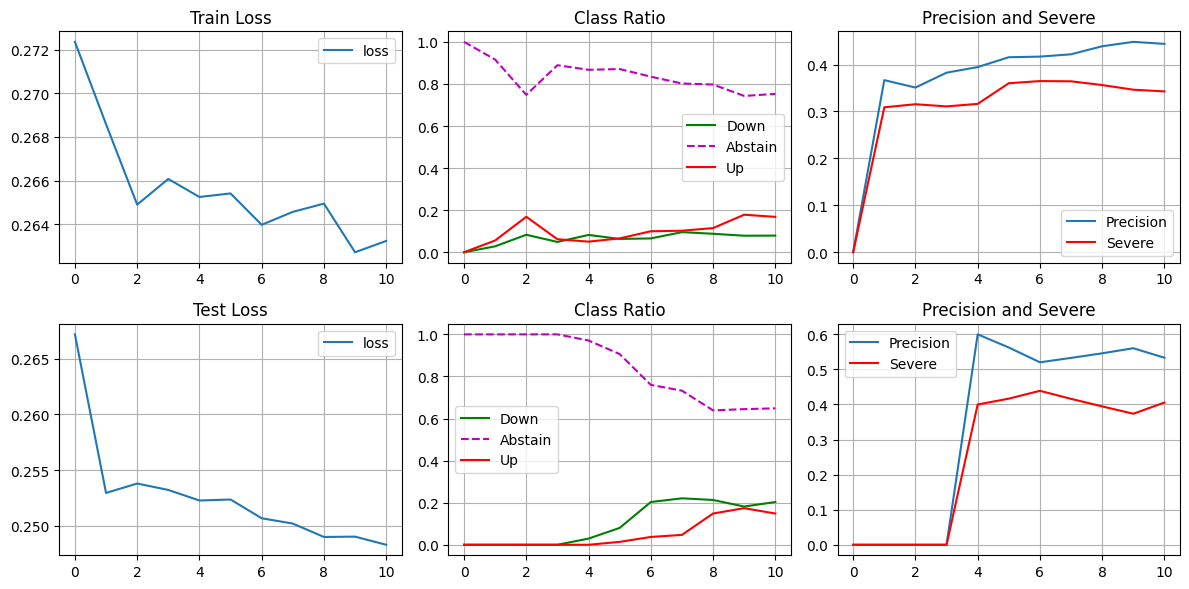

In [61]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)
print("最佳准确率: ", study.best_value)
print("最佳超参数: ", study.best_params)

In [62]:
# all_assets = pd.DataFrame({
#     'stage_1_prediction': np.mean(result, axis = 0)[:,0],
#     'stage_2_prediction': np.mean(result, axis = 0)[:,2],

#     'stage_1_precision': np.mean(result, axis = 0)[:,1],
#     'stage_2_precision': np.mean(result, axis = 0)[:,3],

#     'stage_1_precision_std': np.std(result, axis = 0)[:,1],
#     'stage_2_precision_std': np.std(result, axis = 0)[:,3],
# })
# all_assets.index = pd.Series(assets_list)
# for col in all_assets.columns:
#     all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")

# # 转换为Markdown
# markdown_table = all_assets.to_markdown(index=False)
# print(f'hidden_size: {hidden_size}, num_layers: {num_layers}, seq_len: {seq_len}')
# print(markdown_table)

benchmark
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 21.9%                | 0.0%                 | 15.8%               | 0.0%                | 14.0%                   | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |